<a href="https://colab.research.google.com/github/hc07180011/testing-cv/blob/main/flicker_detection/flicker_detection/colab/testing_cv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/hc07180011/testing-cv.git

Cloning into 'testing-cv'...
remote: Enumerating objects: 1523, done.
remote: Counting objects: 100% (1187/1187), done.
remote: Compressing objects: 100% (896/896), done.
remote: Total 1523 (delta 705), reused 627 (delta 271), pack-reused 336
Receiving objects: 100% (1523/1523), 113.94 MiB | 17.10 MiB/s, done.
Resolving deltas: 100% (864/864), done.


In [ ]:
%cd testing-cv/flicker_detection/flicker_detection/
%pip install -r requirements.txt
%pip install -r requirements_dev.txt
%pip install tensorflow-addons
%pip install coloredlogs rich


/content/testing-cv/flicker_detection/flicker_detection
     |████████████████████████████████| 46 kB 3.4 MB/s 
     |████████████████████████████████| 51 kB 7.4 MB/s 
     |████████████████████████████████| 890 kB 11.3 MB/s 
     |████████████████████████████████| 155 kB 49.1 MB/s 
     |████████████████████████████████| 4.1 MB 41.7 MB/s 
     |████████████████████████████████| 4.1 MB 37.2 MB/s 
     |████████████████████████████████| 86 kB 6.0 MB/s 
     |████████████████████████████████| 61 kB 7.9 MB/s 
     |████████████████████████████████| 1.3 MB 42.4 MB/s 
     |████████████████████████████████| 1.1 MB 38.2 MB/s 
     |████████████████████████████████| 13.3 MB 24.3 MB/s 
     |████████████████████████████████| 11.2 MB 32.1 MB/s 
ERROR: Could not find a version that satisfies the requirement numpy==1.22.1 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11

## logging.py

In [1]:
import sys
import logging

from rich.logging import RichHandler


def init_logger() -> None:
    logger = logging.getLogger("rich")

    FORMAT = "%(name)s[%(process)d] " + \
        "%(processName)s(%(threadName)s) " + \
        "%(module)s:%(lineno)d  %(message)s"

    logger.setLevel(logging.DEBUG)
    formatter = logging.Formatter(
        FORMAT,
        datefmt="%Y%m%d %H:%M:%S"
    )
    logging.basicConfig(
        level="NOTSET", format=FORMAT, handlers=[RichHandler()]
    )

    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter)

    # sys.stdin.reconfigure(encoding="utf-8")
    # sys.stdout.reconfigure(encoding="utf-8")

    logger.addHandler(ch)

    logging.info("Initializing ok.")

## facenet.py

In [9]:
import os
import cv2
import json
import numpy as np
import tensorflow as tf

from tensorflow.keras import metrics
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import resnet, mobilenet
from tensorflow_addons.layers import AdaptiveMaxPooling3D


class Facenet:
    """
    adaptive pooling sample:
    https://ideone.com/cJoN3x
    """
    def __init__(self) -> None:

        super().__init__()

        self.__target_shape = (200, 200)

        np.random.seed(0)

        base_cnn = mobilenet.MobileNet(
            weights="imagenet",
            input_shape=self.__target_shape + (3,),
            include_top=False
        )

        adaptive_1 = AdaptiveMaxPooling3D(
            output_size=(6, 6, 1024))(base_cnn.output)

        output = layers.Dense(256)(adaptive_1)

        adaptive_m = AdaptiveMaxPooling3D(
            output_size=(6, 6, 256))(output)

        self.__embedding = Model(base_cnn.input, adaptive_m,name='Ebedding')
        with open('basecnn_summary.txt', 'w') as fh:
            self.__embedding.summary(print_fn=lambda x: fh.write(x + '\n'))

        for layer in base_cnn.layers[:-23]:
            layer.trainable = False

        anchor_input = layers.Input(
            name="anchor", shape=self.__target_shape + (3,)
        )

        adapt_anchor = AdaptiveMaxPooling3D(
            output_size=(200, 200, 3))(anchor_input)
        adapted_anchor = layers.Input(
            name="adapted_anchor", shape=adapt_anchor.shape, tensor=adapt_anchor)

        positive_input = layers.Input(
            name="positive", shape=self.__target_shape + (3,)
        )

        adapt_positive = AdaptiveMaxPooling3D(
            output_size=(200, 200, 3))(positive_input)
        adapted_positive = layers.Input(
            name="adapted_positive", shape=adapt_positive.shape, tensor=adapt_positive)

        negative_input = layers.Input(
            name="negative", shape=self.__target_shape + (3,)
        )

        adapt_negative = AdaptiveMaxPooling3D(
            output_size=(200, 200, 3))(negative_input)
        adapted_negative = layers.Input(
            name="adapted_negative", shape=adapt_negative.shape, tensor=adapt_negative)

        distances = DistanceLayer()(
            self.__embedding(resnet.preprocess_input(anchor_input)),
            self.__embedding(resnet.preprocess_input(positive_input)),
            self.__embedding(resnet.preprocess_input(negative_input)),
        )

        siamese_network = Model(
            inputs=[
                adapted_anchor,
                adapted_positive,
                adapted_negative,
                anchor_input,
                positive_input,
                negative_input,
            ],
            outputs=distances
        )

        with open('resnet_preprocess_summary.txt', 'w') as fh:
            siamese_network.summary(print_fn=lambda x: fh.write(x + '\n'))

        adaptive_0 = AdaptiveMaxPooling3D(
            output_size=(1024, 6, 6))(siamese_network.output)

        adaptive_siamese_network = Model(siamese_network.input, adaptive_0)

        self.__siamese_model = SiameseModel(adaptive_siamese_network)
        self.__siamese_model.built = True

        with open('adaptive_siamese_summary.txt', 'w') as fh:
            self.__siamese_model.summary(print_fn=lambda x: fh.write(x + '\n'))
        
        model_base_dir = os.path.join("/content/drive/MyDrive/google_cv/flicker_detection_model_architecture/")

        model_settings = json.load(
            open(os.path.join(model_base_dir, "model.json"), "r")
        )
        model_path = os.path.join(model_base_dir, model_settings["name"])
        if os.path.exists(model_path):
            self.__siamese_model.load_weights(model_path)
        else:
            raise NotImplementedError

    def get_embedding(self, images: np.ndarray, batched=True) -> np.ndarray:
        assert (not batched) or len(
            images.shape) == 4, "images should be an array of image with shape (width, height, 3)"
        if not batched:
            images = np.array([images, ])
        resized_images = np.array([cv2.resize(image, dsize=self.__target_shape,
                                              interpolation=cv2.INTER_CUBIC) for image in images])
        image_tensor = tf.convert_to_tensor(resized_images, np.float32)
        return self.__embedding(resnet.preprocess_input(image_tensor)).numpy()


class DistanceLayer(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


class SiameseModel(Model):

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(
            loss, self.siamese_network.trainable_weights)

        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

## keras.py

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, precision_recall_curve, roc_curve, auc


logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("tensorflow").setLevel(logging.WARNING)


class MyMetrics:
    """
    keras metrics api:
    https://keras.io/api/metrics/
    custom sensitivity specificity:
    https://stackoverflow.com/questions/55640149/error-in-keras-when-i-want-to-calculate-the-sensitivity-and-specificity
    custom auc:
    https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras
    """

    def __init__(self) -> None:
        pass

    def precision(self, y_true, y_pred):
        true_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(y_true * y_pred, 0, 1)
            )
        )
        predicted_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(y_pred, 0, 1)
            )
        )
        precision = true_positives / \
            (predicted_positives + tf.keras.backend.epsilon())
        return precision

    def recall(self, y_true, y_pred):
        true_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(y_true * y_pred, 0, 1)
            )
        )
        possible_positives = tf.keras.backend.sum(
            tf.keras.backend.round(
                tf.keras.backend.clip(y_true, 0, 1)
            )
        )
        recall = true_positives / \
            (possible_positives + tf.keras.backend.epsilon())
        return recall

    def f1(self, y_true, y_pred):
        precision = self.precision(y_true, y_pred)
        recall = self.recall(y_true, y_pred)
        return 2 * ((precision * recall) /
                    (precision + recall + tf.keras.backend.epsilon()))

    def auc(self, y_true, y_pred):
        return tf.py_function(auc, (y_true, y_pred), tf.double)

    def specificity(self, y_true, y_pred):
        """
        param:
        y_pred - Predicted labels
        y_true - True labels 
        Returns:
        Specificity score
        """
        neg_y_true = 1 - y_true
        neg_y_pred = 1 - y_pred
        fp = tf.keras.backend.sum(neg_y_true * y_pred)
        tn = tf.keras.backend.sum(neg_y_true * neg_y_pred)
        specificity = tn / (tn + fp + tf.keras.backend.epsilon())
        return specificity


_my_metrics = MyMetrics()


class Model:

    def __init__(
        self,
        model: tf.keras.models.Sequential,
        loss: str,
        optimizer: tf.keras.optimizers,
        metrics: list = list((
            _my_metrics.f1,
            # _my_metrics.auc,
            tf.keras.metrics.AUC(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.Recall(),
            _my_metrics.specificity,
            tf.keras.metrics.SpecificityAtSensitivity(0.5),
            tf.keras.metrics.SensitivityAtSpecificity(0.5),
            'accuracy')),
        summary=True
    ) -> None:
        self.model = model
        self.model.compile(
            loss=loss,
            optimizer=optimizer,
            metrics=metrics
        )
        if summary:
            print(self.model.summary())

    def train(
        self,
        X_train: np.array,
        y_train: np.array,
        epochs: int,
        validation_split: float,
        batch_size: int,
        model_path: str = "model.h5",
        monitor: str = "val_f1",
        mode: str = "max"
    ) -> None:
        self.history = self.model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_split=validation_split,
            batch_size=batch_size,
            callbacks=[
                tf.keras.callbacks.ModelCheckpoint(
                    model_path,
                    save_best_only=True,
                    monitor=monitor,
                    mode=mode
                )
            ]
        )

    def plot_history(self, key: str, title=None) -> None:
        plt.figure(figsize=(16, 4), dpi=200)
        plt.plot(self.history.history["{}".format(key)])
        plt.plot(self.history.history["val_{}".format(key)])
        plt.legend(["{}".format(key), "val_{}".format(key)])
        plt.xlabel("# Epochs")
        plt.ylabel("{}".format(key))
        if title:
            plt.title("{}".format(title))
        plt.savefig("{}.png".format(key))
        plt.close()


class InferenceModel:

    def __init__(
        self,
        model_path: str,
        custom_objects: dict = dict({
            'f1': _my_metrics.f1,
            # 'auc': _my_metrics.auc,
            'auc': tf.keras.metrics.AUC(),
            'precision': tf.keras.metrics.Precision(),
            'recall': tf.keras.metrics.Recall(),
            'specificity': _my_metrics.specificity,
            'spec_at_sen': tf.keras.metrics.SpecificityAtSensitivity(0.5),
            'sen_at_spec': tf.keras.metrics.SensitivityAtSpecificity(0.5), })
    ) -> None:
        self.model = tf.keras.models.load_model(
            model_path,
            custom_objects=custom_objects
        )

    def predict(self, X_test: np.array) -> np.array:
        y_pred = self.model.predict(X_test)
        return y_pred.flatten()

    """
    TO DO if needed plot 
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn+fp)
    """

    def evaluate(self, y_true: np.array, y_pred: np.array) -> None:
        threshold_range = np.arange(0.1, 1.0, 0.001)

        f1_scores = list()
        for lambda_ in threshold_range:
            f1_scores.append(f1_score(y_true, (y_pred > lambda_).astype(int)))

        logging.info("Max f1: {:.4f}, at thres = {:.4f}".format(
            np.max(f1_scores), threshold_range[np.argmax(f1_scores)]
        ))

        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        plt.plot([0, 1], [0, 1], linestyle="dashed")
        plt.plot(fpr, tpr, marker="o")
        plt.plot([0, 0, 1], [0, 1, 1], linestyle="dashed", c="red")
        plt.legend([
            "No Skill",
            "ROC curve (area = {:.2f})".format(auc(fpr, tpr)),
            "Perfect"
        ])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.savefig("roc_curve.png")
        plt.close()

        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        plt.plot([0, 1], [0, 0], linestyle="dashed")
        plt.plot(recall, precision, marker="o")
        plt.legend([
            "No Skill",
            "Model"
        ])
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title("Precision-recall Curve")
        plt.savefig("pc_curve.png")

        print(confusion_matrix(
            y_true,
            (y_pred > threshold_range[np.argmax(f1_scores)]).astype(int)
        ))


## train.py

In [4]:
from typing import Tuple
from argparse import ArgumentParser

import torch
import tqdm

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import LSTM, Dense, Flatten, Bidirectional
from keras.layers.convolutional import Conv1D


data_base_dir = "/content/drive/MyDrive/google_cv"
os.makedirs(data_base_dir, exist_ok=True)
cache_base_dir = ".cache"
os.makedirs(cache_base_dir, exist_ok=True)


def _embed(
    video_data_dir: str,
    output_dir: str
) -> None:
    os.makedirs(output_dir, exist_ok=True)

    facenet = Facenet()
    for path in tqdm.tqdm(os.listdir(video_data_dir)):
        if os.path.exists(os.path.join(output_dir, "{}.npy".format(path))):
            continue

        vidcap = cv2.VideoCapture(os.path.join(video_data_dir, path))
        success, image = vidcap.read()

        embeddings = ()
        while success:
            embeddings = embeddings + tuple(facenet.get_embedding(cv2.resize(
                image, (200, 200)), batched=False)[0].flatten())
            success, image = vidcap.read()

        embeddings = np.array(embeddings)

        np.save(os.path.join(output_dir, path), embeddings)


def _get_chunk_array(input_arr: np.array, chunk_size: int) -> np.array:
    if input_arr.size == 0:
        return np.zeros(1859, dtype=np.uint8).tolist()
    usable_vec = input_arr[:(
        np.floor(len(input_arr)/chunk_size)*chunk_size).astype(int)]

    i_pad = np.concatenate((usable_vec, np.array(
        [input_arr[-1]]*(chunk_size-len(usable_vec) % chunk_size))))
    asymmetric_chunks = np.split(
        i_pad,
        list(range(
            chunk_size,
            input_arr.shape[0] + 1,
            chunk_size
        ))
    )
    return tuple(asymmetric_chunks)


def _preprocess(
    label_path: str,
    mapping_path: str,
    data_dir: str,
    cache_path: str
) -> Tuple[np.array]:
    """
    can consider reducing precision of np.float32 to np.float16 to reduce memory consumption

    abstract:
    https://towardsdatascience.com/overcoming-data-preprocessing-bottlenecks-with-tensorflow-data-service-nvidia-dali-and-other-d6321917f851
    cuda solution:
    https://stackoverflow.com/questions/60996756/how-do-i-assign-a-numpy-int64-to-a-torch-cuda-floattensor
    static memory allocation solution:
    https://pytorch.org/docs/stable/generated/torch.zeros.html
    """
    if os.path.exists("{}.npz".format(cache_path)):
        __cache__ = np.load("{}.npz".format(cache_path), allow_pickle=True)
        return tuple((__cache__[k] for k in __cache__))

    pass_videos = list([
        "0096.mp4", "0097.mp4", "0098.mp4",
        "0125.mp4", "0126.mp4", "0127.mp4",
        "0145.mp4", "0146.mp4", "0147.mp4",
        "0178.mp4", "0179.mp4", "0180.mp4"
    ])
    raw_labels = json.load(open(label_path, "r"))
    encoding_filename_mapping = json.load(open(mapping_path, "r"))

    embedding_path_list = sorted([
        x for x in os.listdir(data_dir)
        if x.split(".npy")[0] not in pass_videos
        and encoding_filename_mapping[x.replace(".npy", "")] in raw_labels
    ])

    embedding_list_train, embedding_list_test, _, _ = train_test_split(
        embedding_path_list,
        list(range(len(embedding_path_list))),
        test_size=0.1,
        random_state=42
    )

    chunk_size = 30

    video_embeddings_list_train = ()
    video_labels_list_train = ()
    logging.debug(
        "taking training chunks, length = {}".format(len(embedding_list_train))
    )
    for path in tqdm.tqdm(embedding_list_train):
        real_filename = encoding_filename_mapping[path.replace(".npy", "")]

        buf_embedding = np.load(os.path.join(data_dir, path))
        if buf_embedding.shape[0] == 0:
            continue

        video_embeddings_list_train = video_embeddings_list_train + \
            (*_get_chunk_array(buf_embedding, chunk_size),)

        flicker_idxs = np.array(raw_labels[real_filename]) - 1
        buf_label = np.zeros(buf_embedding.shape[0]).astype(
            np.uint8) if buf_embedding.shape[0] > 0 else np.zeros(1859, dtype=int).tolist()
        buf_label[flicker_idxs] = 1
        video_labels_list_train = video_labels_list_train + tuple(
            1 if sum(x) else 0
            for x in _get_chunk_array(buf_label, chunk_size)
        )

    video_embeddings_list_test = ()
    video_labels_list_test = ()
    logging.debug(
        "taking testing chunks, length = {}".format(len(embedding_list_test))
    )
    for path in tqdm.tqdm(embedding_list_test):
        real_filename = encoding_filename_mapping[path.replace(".npy", "")]

        buf_embedding = np.load(os.path.join(data_dir, path))
        if buf_embedding.shape[0] == 0:
            continue

        video_embeddings_list_test = video_embeddings_list_test + \
            (*_get_chunk_array(buf_embedding, chunk_size),)

        flicker_idxs = np.array(raw_labels[real_filename]) - 1
        buf_label = np.zeros(buf_embedding.shape[0]).astype(np.uint8)
        buf_label[flicker_idxs] = 1
        video_labels_list_test = video_labels_list_test + tuple(
            1 if sum(x) else 0
            for x in _get_chunk_array(buf_label, chunk_size)
        )
    X_train = np.array(video_embeddings_list_train)
    X_test = np.array(video_embeddings_list_test)
    y_train = np.array(video_labels_list_train)
    y_test = np.array(video_labels_list_test)

    logging.debug("ok. got training: {}/{}, testing: {}/{}".format(
        X_train.shape, y_train.shape,
        X_test.shape, y_test.shape
    ))

    np.savez(cache_path, X_train, X_test, y_train, y_test)

    return (X_train, X_test, y_train, y_test)


def _oversampling(
    X_train: np.array,
    y_train: np.array,
    method="SMOTE"
) -> Tuple[np.array]:
    """
    batched alternative:
    https://imbalanced-learn.org/stable/references/generated/imblearn.keras.BalancedBatchGenerator.html
    """
    train_path = os.path.join(data_base_dir,"flicker_detection_model_architecture/X_train.npy")
    test_path = os.path.join(data_base_dir,"flicker_detection_model_architecture/y_train.npy")
    if os.path.exists(train_path) and os.path.exists(test_path):
        X_train , y_train = np.load(train_path), np.load(test_path)
        logging.info("{}{}".format(X_train.shape, y_train.shape))
        return X_train, y_train

    sm = SMOTE(random_state=42)
    original_X_shape = X_train.shape
    X_train, y_train = sm.fit_resample(
        np.reshape(X_train, (-1, np.prod(original_X_shape[1:]))),
        y_train
    )
    X_train = np.reshape(X_train, (-1,) + original_X_shape[1:])
    np.save("X_train.npy", X_train)
    np.save("y_train.npy", y_train)
    return (X_train, y_train)


def _train(X_train: np.array, y_train: np.array) -> object:
    buf = Sequential()
    buf.add(Bidirectional(LSTM(units=256, activation='sigmoid'),
                          input_shape=(X_train.shape[1:])))
    buf.add(Dense(units=128, activation="sigmoid"))
    buf.add(Flatten())
    buf.add(Dense(units=1, activation="sigmoid"))

    model = Model(
        model=buf,
        loss="binary_crossentropy",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    )
    model.train(X_train, y_train, 1000, 0.1, 1024)
    for k in list(("loss", "accuracy", "f1", "auc", "specificity")):
        model.plot_history(k, title="{} - LSTM, Chunk, Oversampling".format(k))

    return model


def _test(model_path: str, X_test: np.array, y_test: np.array) -> None:
    model = InferenceModel(model_path)
    y_pred = model.predict(X_test)
    model.evaluate(y_test, y_pred)



In [10]:
def pipeline()-> Tuple[np.array]:
    # import gc
    init_logger()

    logging.info("[Embedding] Start ...")
    _embed(
        os.path.join(data_base_dir, "flicker-detection"),
        os.path.join(data_base_dir, "embedding")
    )
    logging.info("[Embedding] done.")

    # gc.collect()
    
    logging.info("[Preprocessing] Start ...")
    X_train, X_test, y_train, y_test = _preprocess(
        os.path.join("/content/drive/MyDrive/google_cv/flicker_detection_model_architecture/", "label.json"),
        os.path.join("/content/drive/MyDrive/google_cv/flicker_detection_model_architecture/", "mapping.json"),
        os.path.join(data_base_dir, "embedding"),
        os.path.join(cache_base_dir, "train_test")
    )
    logging.info("[Preprocessing] done.")

    logging.info("[Oversampling] Start ...")
    X_train, y_train = _oversampling(
        X_train,
        y_train
    )
    logging.info("[Oversampling] done.")
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = pipeline()

[04/03/22 14:27:59] INFO     root[1376]                     ]8;id=554619;file://<ipython-input-1-4b676fa22426>\<ipython-input-1-4b676fa22426>]8;;\:]8;id=374469;file://<ipython-input-1-4b676fa22426>#30\30]8;;\
                             MainProcess(MainThread) <ipyth                                  
                             on-input-1-4b676fa22426>:30                                     
                             Initializing ok.                                                

                    INFO     root[1376]                     ]8;id=990030;file://<ipython-input-10-863391bb9b42>\<ipython-input-10-863391bb9b42>]8;;\:]8;id=205639;file://<ipython-input-10-863391bb9b42>#5\5]8;;\
                             MainProcess(MainThread) <ipyth                                  
                             on-input-10-863391bb9b42>:5                                     
                             [Embedding] Start ...                                           

                    WARNING  tensorflow[1376] MainProcess(MainThread)        ]8;id=982271;file:///usr/local/lib/python3.7/dist-packages/keras/applications/mobilenet.py\mobilenet.py]8;;\:]8;id=693167;file:///usr/local/lib/python3.7/dist-packages/keras/applications/mobilenet.py#226\226]8;;\
                             mobilenet:226  `input_shape` is undefined or                    
                             non-square, or `rows` is not in [128, 160, 192,                 
                             224]. Weights for input shape (224, 224) will                   
                             be loaded as the default.                                       

100%|██████████| 145/145 [00:00<00:00, 1188.60it/s]


[04/03/22 14:28:02] INFO     root[1376]                    ]8;id=324104;file://<ipython-input-10-863391bb9b42>\<ipython-input-10-863391bb9b42>]8;;\:]8;id=930585;file://<ipython-input-10-863391bb9b42>#10\10]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-10-863391bb9b42>:10                                   
                               [Embedding] done.                                             

                    INFO     root[1376]                    ]8;id=787693;file://<ipython-input-10-863391bb9b42>\<ipython-input-10-863391bb9b42>]8;;\:]8;id=513559;file://<ipython-input-10-863391bb9b42>#14\14]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-10-863391bb9b42>:14                                   
                               [Preprocessing] Start ...                                     

[04/03/22 14:28:17] INFO     root[1376]                    ]8;id=507209;file://<ipython-input-10-863391bb9b42>\<ipython-input-10-863391bb9b42>]8;;\:]8;id=167905;file://<ipython-input-10-863391bb9b42>#21\21]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-10-863391bb9b42>:21                                   
                               [Preprocessing] done.                                         

                    INFO     root[1376]                    ]8;id=873568;file://<ipython-input-10-863391bb9b42>\<ipython-input-10-863391bb9b42>]8;;\:]8;id=328937;file://<ipython-input-10-863391bb9b42>#23\23]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-10-863391bb9b42>:23                                   
                               [Oversampling] Start ...                                      

[04/03/22 14:28:25] INFO     root[1376]                    ]8;id=557939;file://<ipython-input-4-1ab586e8972d>\<ipython-input-4-1ab586e8972d>]8;;\:]8;id=64497;file://<ipython-input-4-1ab586e8972d>#180\180]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-4-1ab586e8972d>:180                                   
                               (1858, 30, 9216)(1858,)                                       

                    INFO     root[1376]                    ]8;id=840303;file://<ipython-input-10-863391bb9b42>\<ipython-input-10-863391bb9b42>]8;;\:]8;id=880723;file://<ipython-input-10-863391bb9b42>#28\28]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-10-863391bb9b42>:28                                   
                               [Oversampling] done.                                          

In [19]:
import gc
gc.collect()

88

[04/03/22 15:36:40] INFO     root[1376]                     ]8;id=111172;file://<ipython-input-20-70c0cdcc1dbf>\<ipython-input-20-70c0cdcc1dbf>]8;;\:]8;id=549522;file://<ipython-input-20-70c0cdcc1dbf>#2\2]8;;\
                             MainProcess(MainThread) <ipyth                                  
                             on-input-20-70c0cdcc1dbf>:2                                     
                             [Training] Start ...                                            

                    WARNING  tensorflow[1376] MainProcess(MainThread)    ]8;id=926703;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py\recurrent_v2.py]8;;\:]8;id=756808;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py#1130\1130]8;;\
                             recurrent_v2:1130  Layer lstm_1 will not                        
                             use cuDNN kernels since it doesn't meet the                     
                             criteria. It will use a generic GPU kernel                      
                             as fallback when running on GPU.                                

                    WARNING  tensorflow[1376] MainProcess(MainThread)    ]8;id=113408;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py\recurrent_v2.py]8;;\:]8;id=14719;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py#1130\1130]8;;\
                             recurrent_v2:1130  Layer lstm_1 will not                        
                             use cuDNN kernels since it doesn't meet the                     
                             criteria. It will use a generic GPU kernel                      
                             as fallback when running on GPU.                                

                    WARNING  tensorflow[1376] MainProcess(MainThread)    ]8;id=490982;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py\recurrent_v2.py]8;;\:]8;id=751566;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py#1130\1130]8;;\
                             recurrent_v2:1130  Layer lstm_1 will not                        
                             use cuDNN kernels since it doesn't meet the                     
                             criteria. It will use a generic GPU kernel                      
                             as fallback when running on GPU.                                

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 512)              19400704  
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 128)               65664     
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19,466,497
Trainable params: 19,466,497
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1000
2/2 [==============================] - 10s 4s/step - loss: 0.6839 - f1: 0.0000e+00 - auc: 

[04/03/22 16:41:09] INFO     root[1376]                     ]8;id=586140;file://<ipython-input-20-70c0cdcc1dbf>\<ipython-input-20-70c0cdcc1dbf>]8;;\:]8;id=387851;file://<ipython-input-20-70c0cdcc1dbf>#7\7]8;;\
                             MainProcess(MainThread) <ipyth                                  
                             on-input-20-70c0cdcc1dbf>:7                                     
                             [Training] done.                                                

                    INFO     root[1376]                     ]8;id=24131;file://<ipython-input-20-70c0cdcc1dbf>\<ipython-input-20-70c0cdcc1dbf>]8;;\:]8;id=525606;file://<ipython-input-20-70c0cdcc1dbf>#9\9]8;;\
                             MainProcess(MainThread) <ipyth                                  
                             on-input-20-70c0cdcc1dbf>:9                                     
                             [Testing] Start ...                                             

                    WARNING  tensorflow[1376] MainProcess(MainThread)    ]8;id=755347;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py\recurrent_v2.py]8;;\:]8;id=708322;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py#1130\1130]8;;\
                             recurrent_v2:1130  Layer lstm_1 will not                        
                             use cuDNN kernels since it doesn't meet the                     
                             criteria. It will use a generic GPU kernel                      
                             as fallback when running on GPU.                                

                    WARNING  tensorflow[1376] MainProcess(MainThread)    ]8;id=831759;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py\recurrent_v2.py]8;;\:]8;id=722092;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py#1130\1130]8;;\
                             recurrent_v2:1130  Layer lstm_1 will not                        
                             use cuDNN kernels since it doesn't meet the                     
                             criteria. It will use a generic GPU kernel                      
                             as fallback when running on GPU.                                

                    WARNING  tensorflow[1376] MainProcess(MainThread)    ]8;id=894347;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py\recurrent_v2.py]8;;\:]8;id=274406;file:///usr/local/lib/python3.7/dist-packages/keras/layers/recurrent_v2.py#1130\1130]8;;\
                             recurrent_v2:1130  Layer lstm_1 will not                        
                             use cuDNN kernels since it doesn't meet the                     
                             criteria. It will use a generic GPU kernel                      
                             as fallback when running on GPU.                                

[04/03/22 16:41:13] INFO     root[1376]                   ]8;id=54076;file://<ipython-input-17-3212bc838956>\<ipython-input-17-3212bc838956>]8;;\:]8;id=159586;file://<ipython-input-17-3212bc838956>#183\183]8;;\
                             MainProcess(MainThread) <ipy                                    
                             thon-input-17-3212bc838956>:                                    
                             183  Max f1: 0.4000, at                                         
                             thres = 0.5620                                                  

[[296  22]
 [  5   9]]


                    INFO     root[1376]                    ]8;id=675681;file://<ipython-input-20-70c0cdcc1dbf>\<ipython-input-20-70c0cdcc1dbf>]8;;\:]8;id=967456;file://<ipython-input-20-70c0cdcc1dbf>#11\11]8;;\
                             MainProcess(MainThread) <ipyt                                   
                             hon-input-20-70c0cdcc1dbf>:11                                   
                               [Testing] done.                                               

'\nuse gpu:\nhttps://www.tensorflow.org/guide/gpu\n'

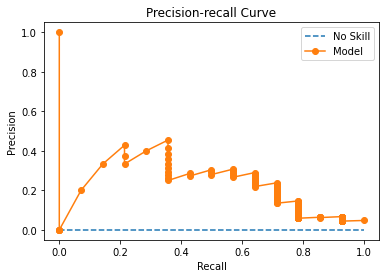

In [20]:
def training(X_train:np.array,y_train:np.array) -> None:
    logging.info("[Training] Start ...")
    model = _train(
        X_train,
        y_train
    )
    logging.info("[Training] done.")

    logging.info("[Testing] Start ...")
    _test("model.h5", X_test, y_test)
    logging.info("[Testing] done.")
    return model


model = training(X_train,y_train)
"""
use gpu:
https://www.tensorflow.org/guide/gpu
"""
# vimdiff ~/googlecv/train.py /home/henrychao/googlecv/train.py

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1
